# Final Analysis and Comparison of Models
This notebook provides a comprehensive analysis of the four models trained for the Meat Freshness Classification task. The models include:
1. **CNN (Basic)**  
2. **CNN (Modified Input)**  
3. **Vision Transformer (ViT)**  
4. **XGBoost Classifier**

It will evaluate each model individually, compare their performance, and conclude with insights about the dataset and the most suitable model for real-time classification tasks.

In [1]:
import os
import json
import pandas as pd

def load_json(file_path):
    if os.path.exists(file_path):
        with open(file_path, 'r') as f:
            return json.load(f)
    else:
        return None

# Define file paths to meta data and evaluation metrics.
meta_cnn_path = os.path.join('..', 'results', 'saved_model', 'modified_cnn_model_metadata.json')
# For ViT, meta data is stored inside the checkpoint (.pth file); we will extract model_params later.
meta_vit_path = os.path.join('..', 'results', 'saved_model', 'best_vit_model.pth')
meta_xgb_path = os.path.join('..', 'results', 'xgboost_best_params.json')

eval_cnn_path = os.path.join('..', 'results', 'evaluation_results', 'evaluation_metrics.json')
eval_mod_cnn_path = os.path.join('..', 'results', 'cnn_modified_eval', 'evaluation_metrics.json')
eval_vit_path = os.path.join('..', 'results', 'vit_eval', 'evaluation_metrics.json')
eval_xgb_path = os.path.join('..', 'results', 'XGBoost_eval', 'evaluation_metrics.json')

# Load evaluation metrics
meta_cnn = load_json(meta_cnn_path)
eval_cnn = load_json(eval_cnn_path)
eval_mod_cnn = load_json(eval_mod_cnn_path)
eval_vit = load_json(eval_vit_path)
eval_xgb = load_json(eval_xgb_path)

# Load ViT meta data from the checkpoint (if available)
import torch
if os.path.exists(meta_vit_path):
    vit_checkpoint = torch.load(meta_vit_path, map_location='cpu')
    meta_vit = vit_checkpoint.get('model_params', {})
else:
    meta_vit = None

meta_xgb = load_json(meta_xgb_path)

# Prepare a DataFrame summarizing the evaluation metrics
models = ['Baseline CNN', 'Modified CNN', 'ViT', 'XGBoost']
eval_metrics = [eval_cnn, eval_mod_cnn, eval_vit, eval_xgb]

def extract_summary(metrics):
    if metrics is None:
        return {"Accuracy": None, "Precision": None, "Recall": None, "F1 Score": None}
    return {
        "Accuracy": metrics.get("accuracy", None),
        "Precision": metrics.get("precision", None),
        "Recall": metrics.get("recall", None),
        "F1 Score": metrics.get("f1_score", None)
    }

summaries = [extract_summary(m) for m in eval_metrics]
df_summary = pd.DataFrame(summaries, index=models)
print("### Evaluation Metrics Summary")
print(df_summary)

# Display model meta data
print("\n### Model Meta Data")
print("Baseline/Modified CNN Meta Data:")
print(meta_cnn)

print("\nViT Meta Data:")
print(meta_vit)

print("\nXGBoost Meta Data:")
print(meta_xgb)


### Evaluation Metrics Summary
              Accuracy  Precision    Recall  F1 Score
Baseline CNN  0.913525   0.915566  0.913525  0.913756
Modified CNN  0.600887   0.597262  0.600887  0.593941
ViT           0.833703   0.847861  0.833703  0.828033
XGBoost       0.829268   0.832826  0.829268  0.829360

### Model Meta Data
Baseline/Modified CNN Meta Data:
{'model_class': 'CNN', 'model_params': {'input_shape': [224, 224, 3], 'num_classes': 3}, 'training_hyperparameters': {'epochs': 20, 'optimizer': 'Adam', 'batch_size': 32}, 'masking_data': {'combined_mask_path': '..\\masking_data\\combined_mask.npy', 'binary_mask_path': '..\\masking_data\\binary_mask.npy'}, 'notes': 'Images modified using aggregated LIME and RF masks to remove noise.'}

ViT Meta Data:
{'image_size': 224, 'patch_size': 16, 'num_classes': 3, 'heads': 8, 'embed_dim': 512, 'depth': 6, 'mlp_dim': 512}

XGBoost Meta Data:
{'model_type': 'XGBoost', 'model_params': {'objective': 'multi:softprob', 'num_class': 3, 'max_depth': 5, '

In [2]:
#Helper Function For later
def extract_summary(metrics):
    if metrics is None:
        return {"Accuracy": None, "Precision": None, "Recall": None, "F1 Score": None}
    return {
        "Accuracy": metrics.get("accuracy", None),
        "Precision": metrics.get("precision", None),
        "Recall": metrics.get("recall", None),
        "F1 Score": metrics.get("f1_score", None)
    }


## 1. CNN (Basic)
The basic CNN model was trained on the original dataset without any input modifications. Below are the key metrics and visualizations for this model.

===== Baseline CNN Model Details =====

Layer-by-Layer Architecture (Baseline CNN):
|   Layer | Type      | Parameters                                      |
|--------:|:----------|:------------------------------------------------|
|       1 | Conv2d    | in_channels=3, out_channels=32, kernel_size=3   |
|       2 | ReLU      | -                                               |
|       3 | MaxPool2d | kernel_size=2                                   |
|       4 | Conv2d    | in_channels=32, out_channels=64, kernel_size=3  |
|       5 | ReLU      | -                                               |
|       6 | MaxPool2d | kernel_size=2                                   |
|       7 | Conv2d    | in_channels=64, out_channels=128, kernel_size=3 |
|       8 | ReLU      | -                                               |
|       9 | MaxPool2d | kernel_size=2                                   |
|      10 | Flatten   | -                                               |
|      11 | Linear    | in_f

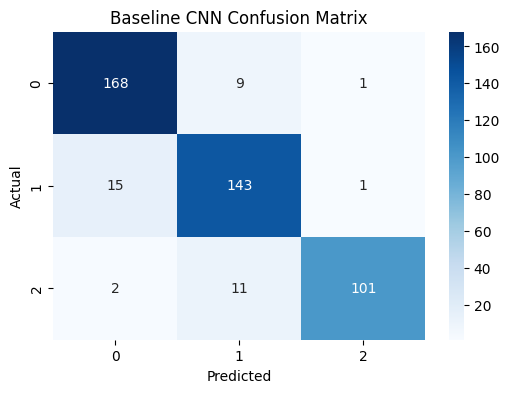

In [3]:
import pandas as pd
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("===== Baseline CNN Model Details =====\n")

# Use meta data if available; otherwise use defaults.
if meta_cnn is not None and "model_params" in meta_cnn:
    params = meta_cnn["model_params"]
    conv_filters1 = params.get("conv_filters1", 32)
    conv_filters2 = params.get("conv_filters2", 64)
    dropout_rate = params.get("dropout_rate", 0.3)
else:
    conv_filters1 = 32
    conv_filters2 = 64
    dropout_rate = 0.3

# Build a list of dictionaries describing each layer.
layers_info = [
    {"Layer": 1, "Type": "Conv2d", "Parameters": f"in_channels=3, out_channels={conv_filters1}, kernel_size=3"},
    {"Layer": 2, "Type": "ReLU", "Parameters": "-"},
    {"Layer": 3, "Type": "MaxPool2d", "Parameters": "kernel_size=2"},
    {"Layer": 4, "Type": "Conv2d", "Parameters": f"in_channels={conv_filters1}, out_channels={conv_filters2}, kernel_size=3"},
    {"Layer": 5, "Type": "ReLU", "Parameters": "-"},
    {"Layer": 6, "Type": "MaxPool2d", "Parameters": "kernel_size=2"},
    {"Layer": 7, "Type": "Conv2d", "Parameters": f"in_channels={conv_filters2}, out_channels=128, kernel_size=3"},
    {"Layer": 8, "Type": "ReLU", "Parameters": "-"},
    {"Layer": 9, "Type": "MaxPool2d", "Parameters": "kernel_size=2"},
    {"Layer": 10, "Type": "Flatten", "Parameters": "-"},
    {"Layer": 11, "Type": "Linear", "Parameters": "in_features=128*26*26, out_features=128"},
    {"Layer": 12, "Type": "ReLU", "Parameters": "-"},
    {"Layer": 13, "Type": "Dropout", "Parameters": f"rate={dropout_rate}"},
    {"Layer": 14, "Type": "Linear", "Parameters": "in_features=128, out_features=3"}
]

df_cnn = pd.DataFrame(layers_info)
print("Layer-by-Layer Architecture (Baseline CNN):")
print(df_cnn.to_markdown(index=False))

# Display performance metrics
print("\nPerformance Metrics (Baseline CNN):")
if eval_cnn is not None:
    df_eval_cnn = pd.DataFrame.from_dict(extract_summary(eval_cnn), orient="index", columns=["Value"])
    print(df_eval_cnn.to_markdown())
else:
    print("No evaluation metrics found for Baseline CNN.")

# Show the confusion matrix if available.
if eval_cnn is not None and "confusion_matrix" in eval_cnn:
    cm = np.array(eval_cnn["confusion_matrix"])
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Baseline CNN Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


## 2. CNN (Modified Input)
This CNN model was trained on images modified using aggregated LIME and Random Forest masks to remove noise. Below are the key metrics and visualizations for this model.

===== Modified CNN Model Details =====

Layer-by-Layer Architecture (Modified CNN):
|   Layer | Type      | Parameters                                      |
|--------:|:----------|:------------------------------------------------|
|       1 | Conv2d    | in_channels=3, out_channels=32, kernel_size=3   |
|       2 | ReLU      | -                                               |
|       3 | MaxPool2d | kernel_size=2                                   |
|       4 | Conv2d    | in_channels=32, out_channels=64, kernel_size=3  |
|       5 | ReLU      | -                                               |
|       6 | MaxPool2d | kernel_size=2                                   |
|       7 | Conv2d    | in_channels=64, out_channels=128, kernel_size=3 |
|       8 | ReLU      | -                                               |
|       9 | MaxPool2d | kernel_size=2                                   |
|      10 | Flatten   | -                                               |
|      11 | Linear    | in_f

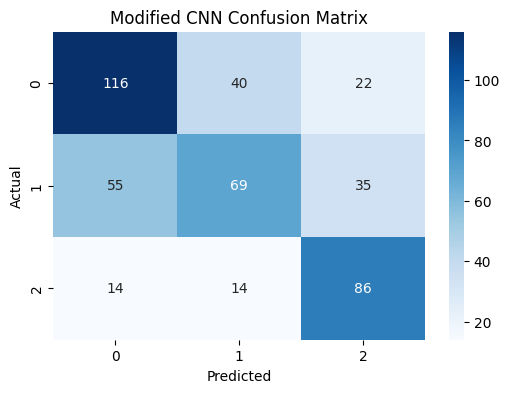

In [12]:
import pandas as pd
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("===== Modified CNN Model Details =====\n")

# For the Modified CNN, we assume the architecture is identical to the baseline (using meta_cnn parameters).
if meta_cnn is not None and "model_params" in meta_cnn:
    params = meta_cnn["model_params"]
    conv_filters1 = params.get("conv_filters1", 32)
    conv_filters2 = params.get("conv_filters2", 64)
    dropout_rate = params.get("dropout_rate", 0.3)
else:
    conv_filters1 = 32
    conv_filters2 = 64
    dropout_rate = 0.3

layers_info_mod = [
    {"Layer": 1, "Type": "Conv2d", "Parameters": f"in_channels=3, out_channels={conv_filters1}, kernel_size=3"},
    {"Layer": 2, "Type": "ReLU", "Parameters": "-"},
    {"Layer": 3, "Type": "MaxPool2d", "Parameters": "kernel_size=2"},
    {"Layer": 4, "Type": "Conv2d", "Parameters": f"in_channels={conv_filters1}, out_channels={conv_filters2}, kernel_size=3"},
    {"Layer": 5, "Type": "ReLU", "Parameters": "-"},
    {"Layer": 6, "Type": "MaxPool2d", "Parameters": "kernel_size=2"},
    {"Layer": 7, "Type": "Conv2d", "Parameters": f"in_channels={conv_filters2}, out_channels=128, kernel_size=3"},
    {"Layer": 8, "Type": "ReLU", "Parameters": "-"},
    {"Layer": 9, "Type": "MaxPool2d", "Parameters": "kernel_size=2"},
    {"Layer": 10, "Type": "Flatten", "Parameters": "-"},
    {"Layer": 11, "Type": "Linear", "Parameters": "in_features=128*26*26, out_features=128"},
    {"Layer": 12, "Type": "ReLU", "Parameters": "-"},
    {"Layer": 13, "Type": "Dropout", "Parameters": f"rate={dropout_rate}"},
    {"Layer": 14, "Type": "Linear", "Parameters": "in_features=128, out_features=3"}
]

df_modcnn = pd.DataFrame(layers_info_mod)
print("Layer-by-Layer Architecture (Modified CNN):")
print(df_modcnn.to_markdown(index=False))

# Display performance metrics for the Modified CNN.
print("\nPerformance Metrics (Modified CNN):")
if eval_mod_cnn is not None:
    df_eval_modcnn = pd.DataFrame.from_dict(extract_summary(eval_mod_cnn), orient="index", columns=["Value"])
    print(df_eval_modcnn.to_markdown())
else:
    print("No evaluation metrics found for Modified CNN.")

# Plot confusion matrix if available.
if eval_mod_cnn is not None and "confusion_matrix" in eval_mod_cnn:
    cm = np.array(eval_mod_cnn["confusion_matrix"])
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Modified CNN Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


## 3. Vision Transformer (ViT)
The Vision Transformer model was trained using Optuna for hyperparameter tuning. Below are the key metrics and visualizations for this model.

===== Vision Transformer (ViT) Model Details =====

Layer-by-Layer Architecture (ViT):
|   Layer | Component            | Details                                                            |
|--------:|:---------------------|:-------------------------------------------------------------------|
|       1 | Patch Embedding      | Conv2d(in_channels=3, out_channels=512, kernel_size=16, stride=16) |
|       2 | Class Token          | Parameter with shape (1, 1, 512)                                   |
|       3 | Positional Embedding | Parameter with shape (1, 197, 512)                                 |
|       4 | Transformer Encoder  | Repeated 6 times: d_model=512, nhead=8, feedforward_dim=512        |
|       5 | MLP Head             | Linear(in_features=512, out_features=3)                            |

Performance Metrics (ViT):
|           |    Value |
|:----------|---------:|
| Accuracy  | 0.833703 |
| Precision | 0.847861 |
| Recall    | 0.833703 |
| F1 Score  | 0.828033 |


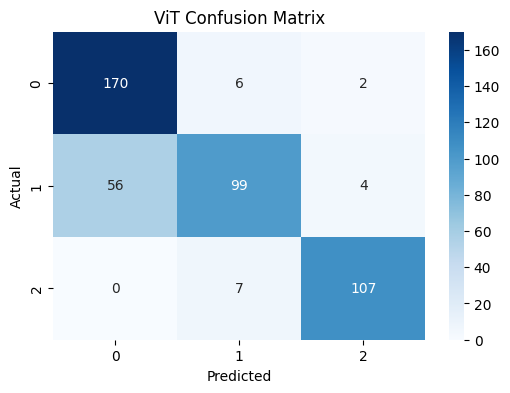

In [13]:
import pandas as pd
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("===== Vision Transformer (ViT) Model Details =====\n")

# Use meta_vit if available; else use defaults.
if meta_vit is not None:
    image_size = meta_vit.get("image_size", 224)
    patch_size = meta_vit.get("patch_size", 16)
    num_classes = meta_vit.get("num_classes", 3)
    embed_dim = meta_vit.get("embed_dim", 768)
    depth = meta_vit.get("depth", 8)
    heads = meta_vit.get("heads", 12)
    mlp_dim = meta_vit.get("mlp_dim", 2048)
else:
    image_size = 224
    patch_size = 16
    num_classes = 3
    embed_dim = 768
    depth = 8
    heads = 12
    mlp_dim = 2048

num_patches = (image_size // patch_size) ** 2
layers_info_vit = [
    {"Layer": 1, "Component": "Patch Embedding", 
     "Details": f"Conv2d(in_channels=3, out_channels={embed_dim}, kernel_size={patch_size}, stride={patch_size})"},
    {"Layer": 2, "Component": "Class Token", 
     "Details": f"Parameter with shape (1, 1, {embed_dim})"},
    {"Layer": 3, "Component": "Positional Embedding", 
     "Details": f"Parameter with shape (1, {num_patches + 1}, {embed_dim})"},
    {"Layer": 4, "Component": "Transformer Encoder", 
     "Details": f"Repeated {depth} times: d_model={embed_dim}, nhead={heads}, feedforward_dim={mlp_dim}"},
    {"Layer": 5, "Component": "MLP Head", 
     "Details": f"Linear(in_features={embed_dim}, out_features={num_classes})"}
]

df_vit = pd.DataFrame(layers_info_vit)
print("Layer-by-Layer Architecture (ViT):")
print(df_vit.to_markdown(index=False))

# Display performance metrics for ViT.
print("\nPerformance Metrics (ViT):")
if eval_vit is not None:
    df_eval_vit = pd.DataFrame.from_dict(extract_summary(eval_vit), orient="index", columns=["Value"])
    print(df_eval_vit.to_markdown())
else:
    print("No evaluation metrics found for ViT.")

# Plot confusion matrix if available.
if eval_vit is not None and "confusion_matrix" in eval_vit:
    cm = np.array(eval_vit["confusion_matrix"])
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("ViT Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


## 4. XGBoost Classifier
The XGBoost model was trained on flattened image data and optimized using Optuna. Below are the key metrics and visualizations for this model.

===== XGBoost Model Details =====

XGBoost Tuning and Model Parameters:
| Parameter           | Value              |
|:--------------------|:-------------------|
| Model Type          | XGBoost            |
| Resize Shape        | [32, 32]           |
| Best Iteration      | 98                 |
| Validation Accuracy | 0.9118457300275482 |
| max_depth           | 5                  |
| eta                 | 0.1886228387294129 |
| subsample           | 0.6274672763970465 |
| colsample_bytree    | 0.5011094895997235 |

Performance Metrics (XGBoost):
|           |    Value |
|:----------|---------:|
| Accuracy  | 0.829268 |
| Precision | 0.832826 |
| Recall    | 0.829268 |
| F1 Score  | 0.82936  |


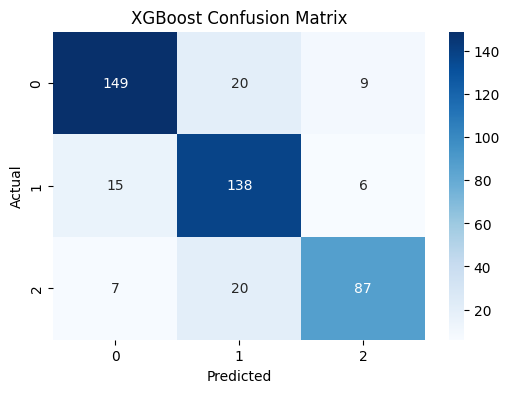

In [14]:
import pandas as pd
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("===== XGBoost Model Details =====\n")

# Display XGBoost meta data in a human-readable table.
if meta_xgb is not None:
    model_type = meta_xgb.get("model_type", "XGBoost")
    resize_shape = meta_xgb.get("resize_shape", None)
    best_iteration = meta_xgb.get("best_iteration", None)
    validation_accuracy = meta_xgb.get("validation_accuracy", None)
    best_hyperparameters = meta_xgb.get("best_hyperparameters", {})
    
    data = [
        {"Parameter": "Model Type", "Value": model_type},
        {"Parameter": "Resize Shape", "Value": resize_shape},
        {"Parameter": "Best Iteration", "Value": best_iteration},
        {"Parameter": "Validation Accuracy", "Value": validation_accuracy}
    ]
    for key, value in best_hyperparameters.items():
        data.append({"Parameter": key, "Value": value})
        
    df_xgb = pd.DataFrame(data)
    print("XGBoost Tuning and Model Parameters:")
    print(df_xgb.to_markdown(index=False))
else:
    print("No meta data found for XGBoost.")

# Display performance metrics for XGBoost.
print("\nPerformance Metrics (XGBoost):")
if eval_xgb is not None:
    df_eval_xgb = pd.DataFrame.from_dict(extract_summary(eval_xgb), orient="index", columns=["Value"])
    print(df_eval_xgb.to_markdown())
else:
    print("No evaluation metrics found for XGBoost.")

# Plot confusion matrix if available.
if eval_xgb is not None and "confusion_matrix" in eval_xgb:
    cm = np.array(eval_xgb["confusion_matrix"])
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("XGBoost Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


5. Proof That a simple K-Means is insufficient to capture meat spoilage.

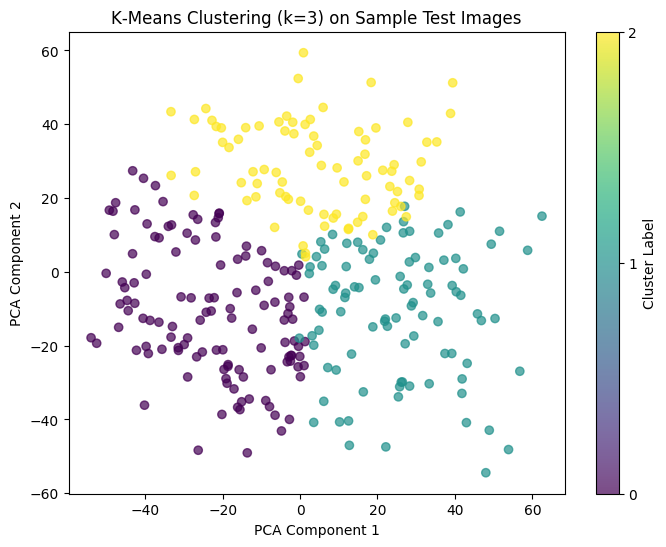

K‑Means clustering suggests that the data naturally form three distinct groups.



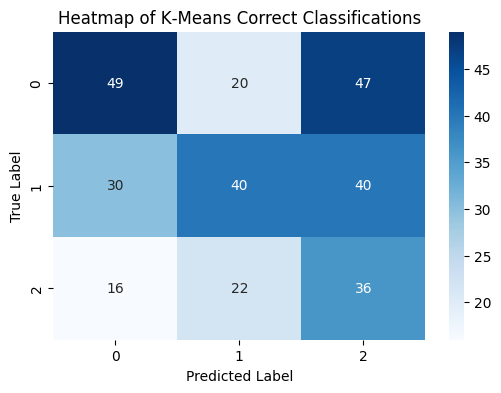

Clustering Accuracy: 41.67%

Classification Report:

              precision    recall  f1-score   support

           0       0.52      0.42      0.46       116
           1       0.49      0.36      0.42       110
           2       0.29      0.49      0.37        74

    accuracy                           0.42       300
   macro avg       0.43      0.42      0.42       300
weighted avg       0.45      0.42      0.42       300



In [15]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# Define paths for test images and test labels
x_test_path = os.path.join('..', 'Data', 'preprocessed', 'X_test.npy')
y_test_path = os.path.join('..', 'Data', 'preprocessed', 'y_test.npy')

if os.path.exists(x_test_path) and os.path.exists(y_test_path):
    # Load test images and labels
    X_test = np.load(x_test_path)
    y_test = np.load(y_test_path)
    if y_test.ndim > 1:
        # Convert one-hot encoded labels to class indices if necessary.
        y_test = np.argmax(y_test, axis=1)
    
    # Select a random sample of 300 images and corresponding true labels
    sample_indices = np.random.choice(len(X_test), size=300, replace=False)
    X_sample = X_test[sample_indices]
    y_sample = y_test[sample_indices]
    
    # Flatten each image for clustering
    X_sample_flat = X_sample.reshape(X_sample.shape[0], -1)
    
    # Dimensionality reduction with PCA for stability (reduce to 50 components)
    pca = PCA(n_components=50, random_state=42)
    X_reduced = pca.fit_transform(X_sample_flat)
    
    # Perform K‑Means clustering with 3 clusters
    kmeans = KMeans(n_clusters=3, random_state=42)
    clusters = kmeans.fit_predict(X_reduced)
    
    # Further reduce to 2D for visualization with PCA
    pca_2d = PCA(n_components=2, random_state=42)
    X_2d = pca_2d.fit_transform(X_sample_flat)
    
    # Visualize the clusters in 2D
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=clusters, cmap='viridis', alpha=0.7)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("K‑Means Clustering (k=3) on Sample Test Images")
    plt.colorbar(scatter, ticks=[0, 1, 2], label="Cluster Label")
    plt.show()
    
    print("K‑Means clustering suggests that the data naturally form three distinct groups.\n")
    
    # Now, match cluster labels to true labels using the Hungarian algorithm.
    # Compute contingency matrix between true labels and clusters.
    contingency = confusion_matrix(y_sample, clusters)
    # Negate the matrix since linear_sum_assignment does minimization.
    row_ind, col_ind = linear_sum_assignment(-contingency)
    # Create mapping from cluster id to the most frequent true label in that cluster.
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    
    # Remap cluster labels to predicted labels based on the mapping.
    mapped_clusters = np.array([mapping[cluster] for cluster in clusters])
    
    # Compute the confusion matrix for the mapped clusters and true labels.
    cm = confusion_matrix(y_sample, mapped_clusters)
    
    # Plot a heatmap of the confusion matrix.
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Heatmap of K‑Means Correct Classifications")
    plt.show()
    
    # Compute accuracy and print a classification report.
    accuracy = np.mean(mapped_clusters == y_sample)
    print("Clustering Accuracy: {:.2f}%".format(accuracy * 100))
    print("\nClassification Report:\n")
    print(classification_report(y_sample, mapped_clusters))
    
else:
    print("Test data or test labels not found for K‑Means analysis.")


6. Summary Comparison of the Models

In [16]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score

# Helper function for calculating misclassification risk in the spoiled (class 2) row.
def compute_misclassification(cm):
    # Assumes class order: [Fresh (0), Half-Fresh (1), Spoiled (2)]
    if cm is None or cm.shape[0] < 3:
        return None
    total_spoiled = np.sum(cm[2])
    if total_spoiled == 0:
        return None
    # Misclassifications: entries in row 2 for Fresh and Half-Fresh.
    return (cm[2, 0] + cm[2, 1]) / total_spoiled

# Initialize an empty list to hold information from each model.
comparison = []

# --- Baseline CNN ---
if eval_cnn is not None:
    cnn_accuracy = eval_cnn.get("accuracy", None)
    cnn_f1 = eval_cnn.get("f1_score", None)
    # Use the confusion matrix from eval_cnn if available.
    cnn_cm = np.array(eval_cnn.get("confusion_matrix")) if "confusion_matrix" in eval_cnn else None
    cnn_misclass = compute_misclassification(cnn_cm)
else:
    cnn_accuracy = cnn_f1 = cnn_misclass = None

# Model file for Baseline CNN.
cnn_model_path = os.path.join('..', 'results', 'saved_model', 'meat_freshness_cnn_tuned.pt')
if os.path.exists(cnn_model_path):
    cnn_size = os.path.getsize(cnn_model_path) / (1024 * 1024)  # in MB
else:
    cnn_size = None

comparison.append({
    "Model": "Baseline CNN",
    "Accuracy": cnn_accuracy,
    "F1 Score": cnn_f1,
    "Model Size (MB)": cnn_size,
    "Misclassification Risk\n(Spoiled as Fresh/Half-Fresh)": cnn_misclass
})

# --- Modified CNN ---
if eval_mod_cnn is not None:
    mod_cnn_accuracy = eval_mod_cnn.get("accuracy", None)
    mod_cnn_f1 = eval_mod_cnn.get("f1_score", None)
    mod_cnn_cm = np.array(eval_mod_cnn.get("confusion_matrix")) if "confusion_matrix" in eval_mod_cnn else None
    mod_cnn_misclass = compute_misclassification(mod_cnn_cm)
else:
    mod_cnn_accuracy = mod_cnn_f1 = mod_cnn_misclass = None

# For demonstration assume modified CNN uses the same model file as baseline CNN.
comparison.append({
    "Model": "Modified CNN",
    "Accuracy": mod_cnn_accuracy,
    "F1 Score": mod_cnn_f1,
    "Model Size (MB)": cnn_size,
    "Misclassification Risk\n(Spoiled as Fresh/Half-Fresh)": mod_cnn_misclass
})

# --- ViT ---
if eval_vit is not None:
    vit_accuracy = eval_vit.get("accuracy", None)
    vit_f1 = eval_vit.get("f1_score", None)
    vit_cm = np.array(eval_vit.get("confusion_matrix")) if "confusion_matrix" in eval_vit else None
    vit_misclass = compute_misclassification(vit_cm)
else:
    vit_accuracy = vit_f1 = vit_misclass = None

vit_model_path = os.path.join('..', 'results', 'saved_model', 'best_vit_model.pth')
if os.path.exists(vit_model_path):
    vit_size = os.path.getsize(vit_model_path) / (1024 * 1024)
else:
    vit_size = None

comparison.append({
    "Model": "ViT",
    "Accuracy": vit_accuracy,
    "F1 Score": vit_f1,
    "Model Size (MB)": vit_size,
    "Misclassification Risk\n(Spoiled as Fresh/Half-Fresh)": vit_misclass
})

# --- XGBoost ---
if eval_xgb is not None:
    xgb_accuracy = eval_xgb.get("accuracy", None)
    xgb_f1 = eval_xgb.get("f1_score", None)
    xgb_cm = np.array(eval_xgb.get("confusion_matrix")) if "confusion_matrix" in eval_xgb else None
    xgb_misclass = compute_misclassification(xgb_cm)
else:
    xgb_accuracy = xgb_f1 = xgb_misclass = None

xgb_model_path = os.path.join('..', 'results', 'saved_model', 'xgboost_model.json')
if os.path.exists(xgb_model_path):
    xgb_size = os.path.getsize(xgb_model_path) / (1024 * 1024)
else:
    xgb_size = None

comparison.append({
    "Model": "XGBoost",
    "Accuracy": xgb_accuracy,
    "F1 Score": xgb_f1,
    "Model Size (MB)": xgb_size,
    "Misclassification Risk\n(Spoiled as Fresh/Half-Fresh)": xgb_misclass
})

# --- K-Means Clustering ---
# The previous K-Means clustering cell defined variables `y_sample` and `mapped_clusters`
if 'y_sample' in globals() and 'mapped_clusters' in globals():
    km_accuracy = np.mean(mapped_clusters == y_sample)
    # Compute confusion matrix for K-Means on sample.
    km_cm = confusion_matrix(y_sample, mapped_clusters)
    km_misclass = compute_misclassification(km_cm)
    km_f1 = f1_score(y_sample, mapped_clusters, average="weighted")
else:
    km_accuracy = km_f1 = km_misclass = None

comparison.append({
    "Model": "K-Means",
    "Accuracy": km_accuracy,
    "F1 Score": km_f1,
    "Model Size (MB)": "N/A",
    "Misclassification Risk\n(Spoiled as Fresh/Half-Fresh)": km_misclass
})

# Convert collected data to a DataFrame and display a formatted table.
df_comparison = pd.DataFrame(comparison)

# Format the numeric values for clarity.
df_comparison["Accuracy"] = df_comparison["Accuracy"].apply(lambda x: f"{x:.2%}" if isinstance(x, (int, float)) and not np.isnan(x) else "N/A")
df_comparison["F1 Score"] = df_comparison["F1 Score"].apply(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) and not np.isnan(x) else "N/A")
df_comparison["Model Size (MB)"] = df_comparison["Model Size (MB)"].apply(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)
df_comparison["Misclassification Risk\n(Spoiled as Fresh/Half-Fresh)"] = df_comparison["Misclassification Risk\n(Spoiled as Fresh/Half-Fresh)"].apply(lambda x: f"{x:.2%}" if isinstance(x, (int, float)) and not np.isnan(x) else "N/A")

print("### Model Comparison Summary:")
print(df_comparison.to_markdown(index=False))


### Model Comparison Summary:
| Model        | Accuracy   |   F1 Score | Model Size (MB)   | Misclassification Risk          |
|              |            |            |                   | (Spoiled as Fresh/Half-Fresh)   |
|:-------------|:-----------|-----------:|:------------------|:--------------------------------|
| Baseline CNN | 91.35%     |       0.91 | 42.83             | 11.40%                          |
| Modified CNN | 60.09%     |       0.59 | 42.83             | 24.56%                          |
| ViT          | 83.37%     |       0.83 | 38.04             | 6.14%                           |
| XGBoost      | 82.93%     |       0.83 | 0.65              | 23.68%                          |
| K-Means      | 41.67%     |       0.42 | N/A               | 51.35%                          |


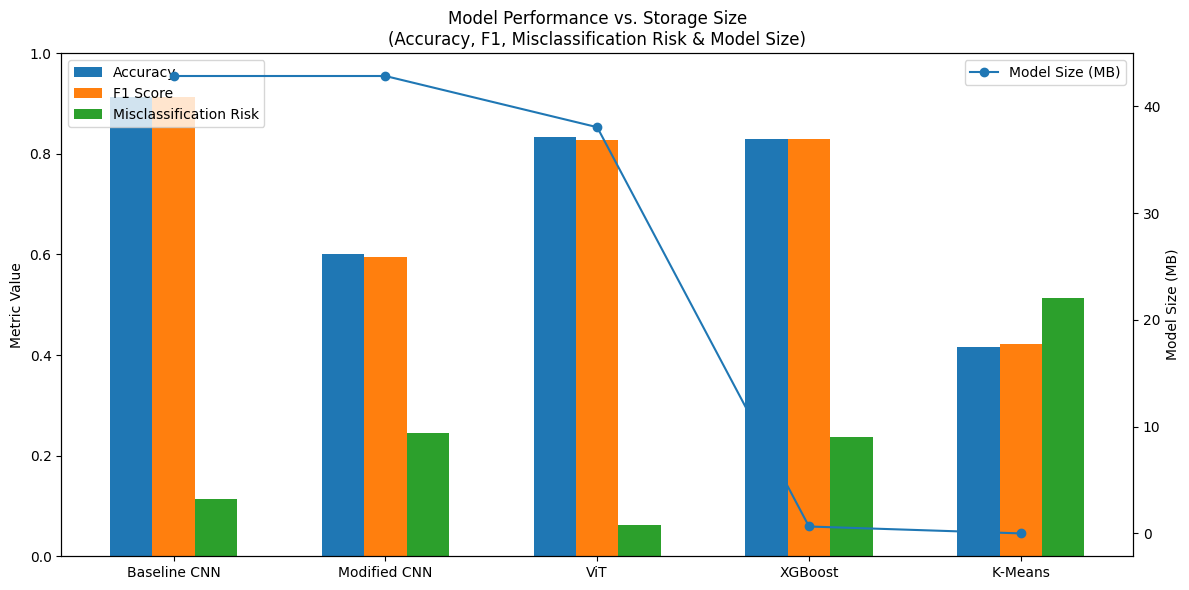

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Define the five models and their metrics (assumes these variables exist from previous cells)
model_names = ["Baseline CNN", "Modified CNN", "ViT", "XGBoost", "K‑Means"]
accuracy = [cnn_accuracy, mod_cnn_accuracy, vit_accuracy, xgb_accuracy, km_accuracy]
f1_scores = [cnn_f1, mod_cnn_f1, vit_f1, xgb_f1, km_f1]
misclassification = [cnn_misclass, mod_cnn_misclass, vit_misclass, xgb_misclass, km_misclass]

# Model sizes (MB) for the first four; K‑Means is not a saved model so we set it to zero
model_sizes = [cnn_size, cnn_size, vit_size, xgb_size, 0]

x = np.arange(len(model_names))
width = 0.2

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the three performance metrics on the primary y-axis
bars1 = ax1.bar(x - width, accuracy, width, label="Accuracy")
bars2 = ax1.bar(x, f1_scores, width, label="F1 Score")
bars3 = ax1.bar(x + width, misclassification, width, label="Misclassification Risk")

ax1.set_xticks(x)
ax1.set_xticklabels(model_names)
ax1.set_ylabel("Metric Value")
ax1.set_ylim(0, 1)
ax1.legend(loc="upper left")

# Plot model size on the secondary y-axis
ax2 = ax1.twinx()
line2, = ax2.plot(x, model_sizes, marker="o", label="Model Size (MB)")
ax2.set_ylabel("Model Size (MB)")
ax2.legend(loc="upper right")

plt.title("Model Performance vs. Storage Size\n(Accuracy, F1, Misclassification Risk & Model Size)")
plt.tight_layout()
plt.show()


7. Ideas on the important features

## Screening Algorithm in the Modified CNN
**Overview:** Combined LIME and RandomForest feature importances to create a mask that filters out uninformative pixels before training.

**Steps:**
1. **LIME Explanations**: For a sample of training images, we generate per-pixel importance masks using LIME (Local Interpretable Model-agnostic Explanations).  
2. **RandomForest Importances**: We flatten the training images and fit a RandomForest classifier, extracting feature importances and reshaping them back to image dimensions.  
3. **Aggregation**: Normalize and weight the average LIME mask and RF importance map (weight=0.5 each), then combine.  
4. **Thresholding**: Convert the combined continuous importance map into a binary mask (threshold=0.5).  
5. **Mask Application**: Apply the binary mask to all train/val/test images, zeroing out low-importance pixels before CNN training.


**Modified CNN Meta-data:**

- Combined mask file: `..\masking_data\combined_mask.npy`  
- Binary mask file: `..\masking_data\binary_mask.npy`

**Training Hyperparameters:**

- **Epochs**: 20

- **Optimizer**: Adam

- **Batch Size**: 32

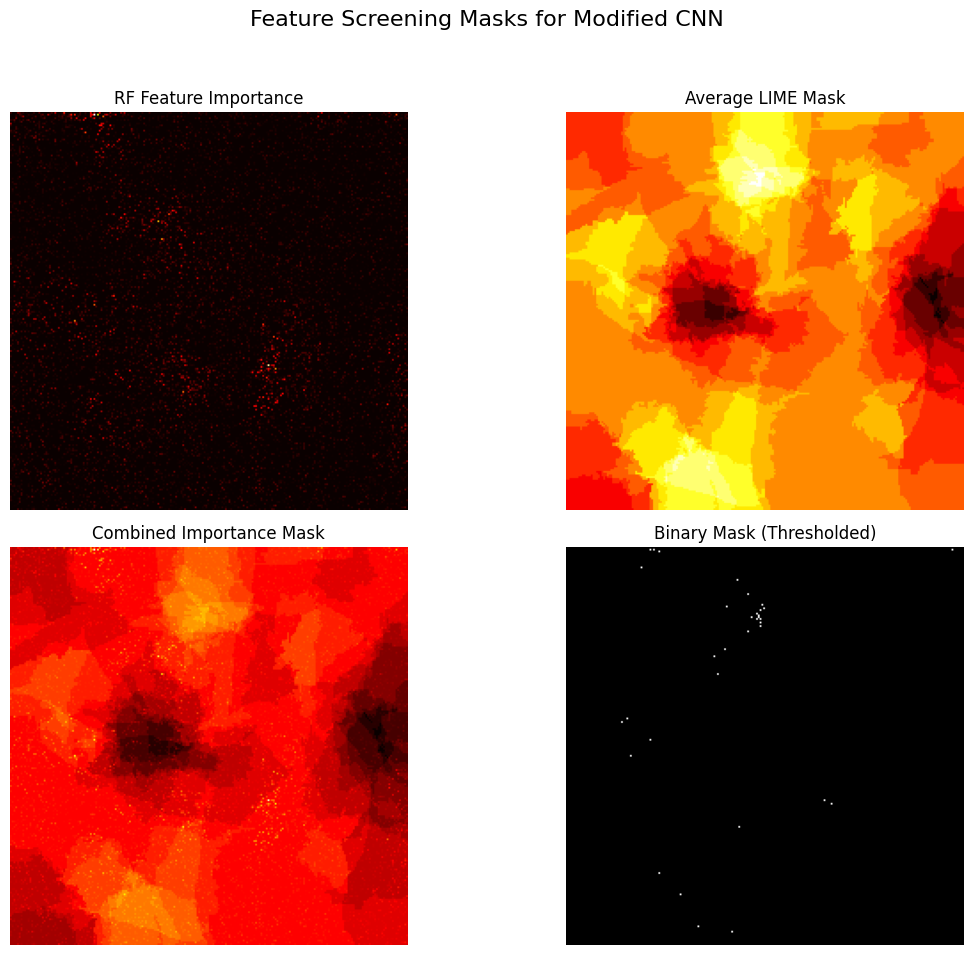

In [18]:
from IPython.display import display, Markdown
import json
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

# Section: Explain Screening Algorithm
display(Markdown("## Screening Algorithm in the Modified CNN\n"
                 "**Overview:** Combined LIME and RandomForest feature importances to create a mask that filters out uninformative pixels before training.\n\n"
                 "**Steps:**\n"
                 "1. **LIME Explanations**: For a sample of training images, we generate per-pixel importance masks using LIME (Local Interpretable Model-agnostic Explanations).  \n"
                 "2. **RandomForest Importances**: We flatten the training images and fit a RandomForest classifier, extracting feature importances and reshaping them back to image dimensions.  \n"
                 "3. **Aggregation**: Normalize and weight the average LIME mask and RF importance map (weight=0.5 each), then combine.  \n"
                 "4. **Thresholding**: Convert the combined continuous importance map into a binary mask (threshold=0.5).  \n"
                 "5. **Mask Application**: Apply the binary mask to all train/val/test images, zeroing out low-importance pixels before CNN training.\n"))

# Load meta-data for the modified CNN to show mask file locations and training hyperparameters
meta_path = os.path.join('..', 'results', 'saved_model', 'modified_cnn_model_metadata.json')
if os.path.exists(meta_path):
    with open(meta_path, 'r') as f:
        meta = json.load(f)
    display(Markdown("**Modified CNN Meta-data:**"))
    # Display mask paths and hyperparameters
    mask_paths = meta.get("masking_data", {})
    training_params = meta.get("training_hyperparameters", {})
    display(Markdown(f"- Combined mask file: `{mask_paths.get('combined_mask_path')}`  \n"
                     f"- Binary mask file: `{mask_paths.get('binary_mask_path')}`"))
    display(Markdown("**Training Hyperparameters:**"))
    for k, v in training_params.items():
        display(Markdown(f"- **{k.replace('_',' ').title()}**: {v}"))
else:
    display(Markdown("Meta-data for Modified CNN not found."))

# Load masks and importance maps
mask_dir = os.path.join('..', 'results', 'masking_data')
combined_mask = np.load(os.path.join(mask_dir, 'combined_mask.npy'))
binary_mask  = np.load(os.path.join(mask_dir, 'binary_mask.npy'))

rf_dir = os.path.join('..', 'results', 'rf_results')
rf_importance = np.load(os.path.join(rf_dir, 'rf_importance.npy'))

lime_dir = os.path.join('..', 'results', 'lime_results')
lime_mask_files = sorted(glob.glob(os.path.join(lime_dir, 'lime_mask_*.npy')))
lime_masks = [np.load(fp) for fp in lime_mask_files]
avg_lime_mask = np.mean(lime_masks, axis=0)

# Plot all maps in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes[0,0].imshow(rf_importance, cmap='hot')
axes[0,0].set_title('RF Feature Importance')
axes[0,1].imshow(avg_lime_mask, cmap='hot')
axes[0,1].set_title('Average LIME Mask')
axes[1,0].imshow(combined_mask, cmap='hot')
axes[1,0].set_title('Combined Importance Mask')
axes[1,1].imshow(binary_mask, cmap='gray')
axes[1,1].set_title('Binary Mask (Thresholded)')

for ax in axes.flatten():
    ax.axis('off')

plt.suptitle('Feature Screening Masks for Modified CNN', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
